In [22]:
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
import plotly.graph_objects as go

# This File combines Stock Market Data, FED & NLP data for use in Downstream Classification Models

Reading in DF and Merging files

In [5]:
df = pd.read_csv('Excel_data/test_60_40_advanced.csv')
fed_data = pd.read_csv('Excel_data/Full_Fed_Minutes_test.csv')
NER_data = pd.read_csv('Excel_data/NLP_FOMC_people_07_19.csv')
NER_data = NER_data.rename(columns={'Unnamed: 0':'Date'})

fed_df = pd.DataFrame(fed_data)
fed_df = fed_df.rename(columns={'index':'Date'})
fed_df=fed_df.drop(['Unnamed: 0'], axis=1)
df = pd.DataFrame(df)
df = pd.merge(df,fed_df, how='left', on = 'Date', suffixes = ('_left', '_right'))
df =df.drop(columns={'Score'})
df.head(36)

window = 2

In [5]:
# Uncomment to Examine DF
##fed_df

#### Located Below is the List of Tickers Currently Included in the ETF Data Fetch python File
These lists allow for later parsing

In [6]:
# tickers to aggregate price only
ticker_test = ['XLE','XLU','XLK','XLB','XLP','XLY','XLI','XLC','XLV','XLF','XLRE','TLT','SJNK','SPTI','LQD']
bond_list = ['TLT','SJNK','SPTI','LQD']
equities_list = ['XLE','XLU','XLK','XLB','XLP','XLY','XLI','XLC','XLV','XLF','XLRE','SPY']

Quick Data Examination

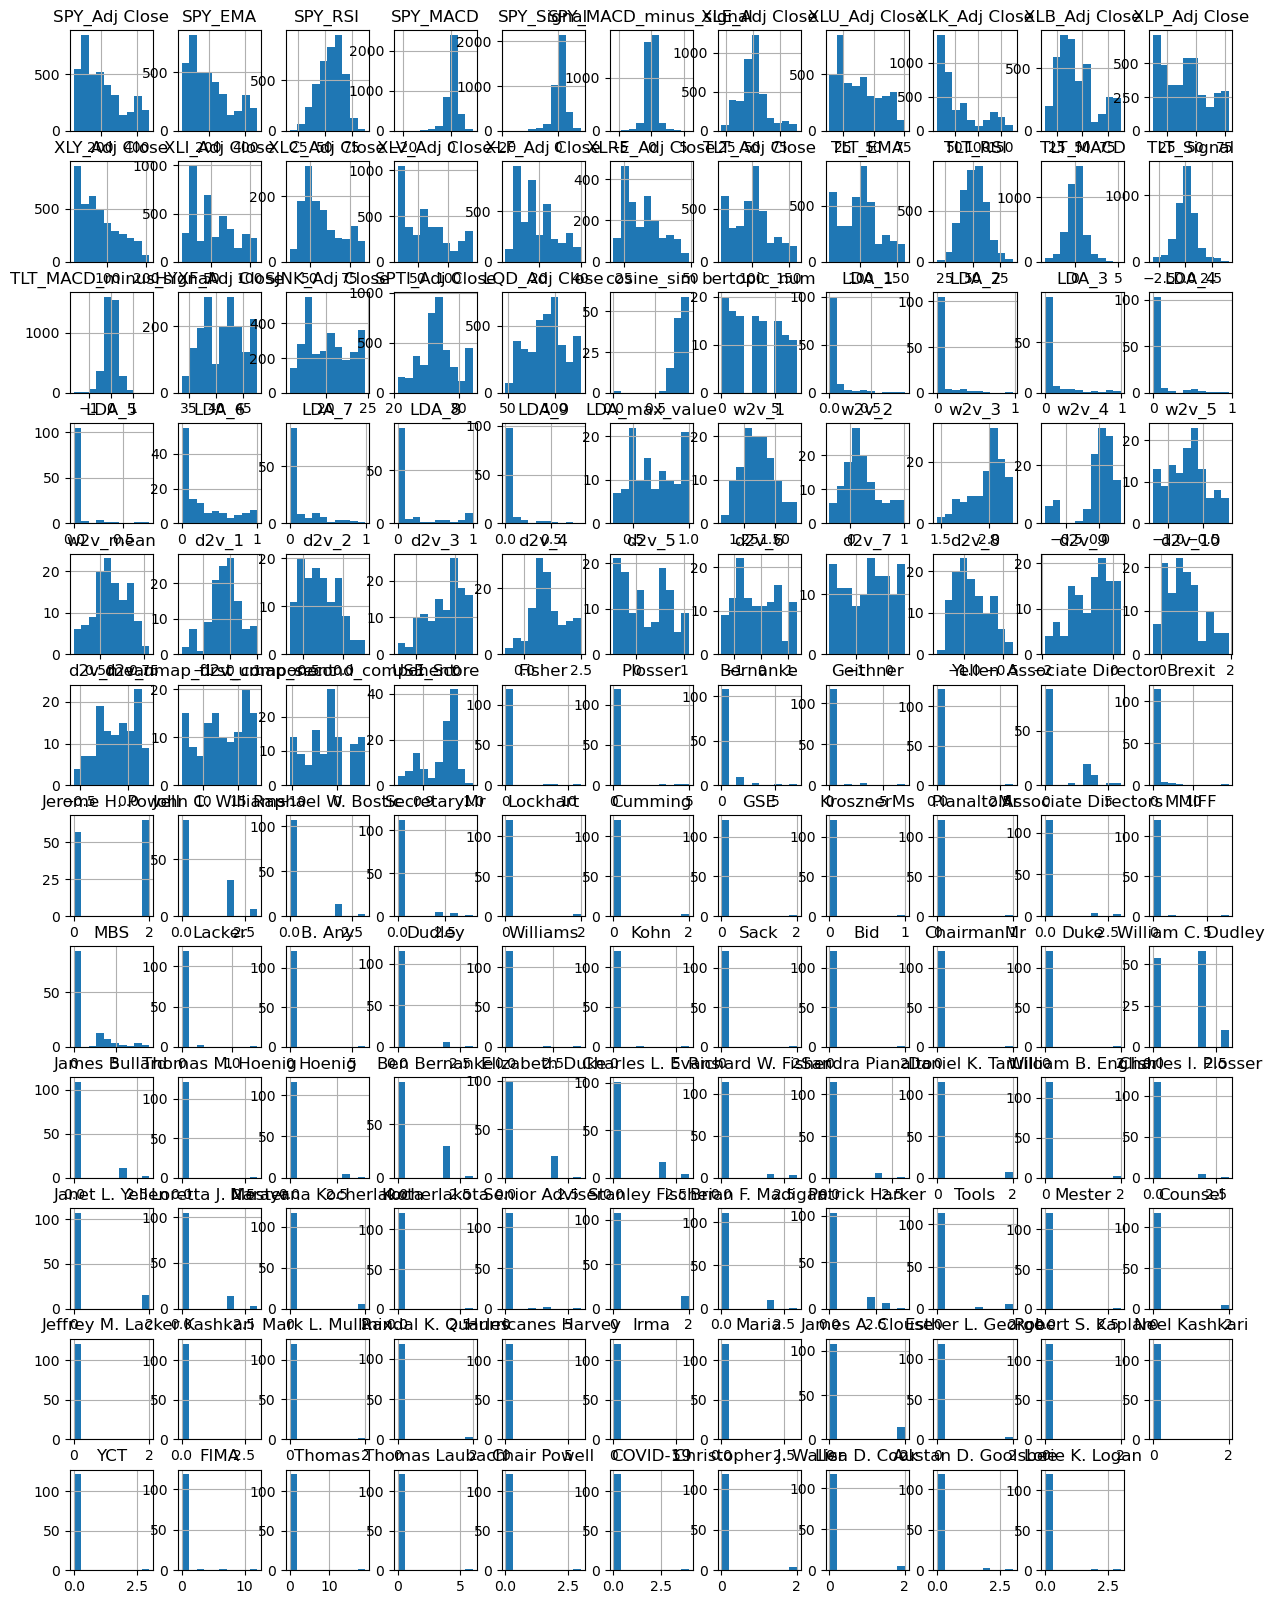

In [7]:
# Plotting DF to understand ETF returns and how to Scale if needed
df.hist(figsize=(15,20))

plt.show()

# Functions

In [8]:
# This function creates a window around a specific date to calculate averages. A window of 2 gives 2 days before and 2 days after a date
def window_func(df,i,window):
    window_1 = window+1
    
    if df['Date'].str.contains(str(i)).sum() >0:
        idx = df[df['Date']==str(i)].index
        
        df_out = df.iloc[idx[0]-window : idx[0]+window_1]
        
        return df_out

In [9]:
def Fed_Date_Avg(fed_df,df, window):
    release_window_df = []
    for i in fed_df['Date']:

        out = window_func(df,i,window)
        out = pd.DataFrame(out).mean(numeric_only=True) # not sure why it wants me to force the df call again
        
        release_window_df.append(out)

    result = release_window_df
    avg_df = pd.DataFrame(result)
    num_df = avg_df.loc[:, avg_df.columns!='Score'] # removing sentiment score from percentage change calculation. (For Now)

    log_df = num_df.pct_change()

    Final_df = log_df.assign(Date=fed_df['Date'],Sent_TFMR=fed_df['Score']) # append non percentage change columns back



    first_column = Final_df.pop('Date') # moving date to the left column, popping it off first
    

    Final_df.insert(0, 'Date', first_column) # re inserting it 

    return Final_df

In [10]:
# This function combines Named Entity Recognition data
def add_NER(df,NER_data):
    combined_df = pd.merge(df,NER_data, how='left', on = 'Date', suffixes = ('_left', '_right'))
    return combined_df

In [23]:
# This function calculates the forward return of the SPY Index
def Forward_Return(Final_df,fed_df):
   
    Full_df= Final_df[Final_df['Date'].isin(fed_df['Date'])]
    Full_df['Return_Next_FOMC'] = Full_df['SPY_Adj Close'].shift(-1)-Full_df['SPY_Adj Close'] # take close since last fed meeting and subtract from previous to get change for the period

    for i in ticker_test:
        Full_df['Return_Next_FOMC '+(i)] = Full_df[(i)+'_Adj Close'].shift(-1)-Full_df[(i)+'_Adj Close']    


    return Full_df

In [24]:
# This function calculates the forward return of the SPY Index
def Forward_Return(Final_df,fed_df):
   
    Full_df= Final_df[Final_df['Date'].isin(fed_df['Date'])]
    Full_df['Return_Next_FOMC'] = Full_df['SPY_Adj Close'].shift(-1)-Full_df['SPY_Adj Close'] # take close since last fed meeting and subtract from previous to get change for the period

    for i in ticker_test:
        Full_df['Return_Next_FOMC '+(i)] = Full_df[(i)+'_Adj Close'].shift(-1)-Full_df[(i)+'_Adj Close']    


    return Full_df

In [25]:
# This Function classifies Bull or Bear markets 
def Bull_bear(df):
    df['Bull_Bear'] = 0
    df.loc[df['Return_Next_FOMC'] > 0, 'Bull_Bear'] = 1
    return df

In [26]:
Final_df = Fed_Date_Avg(fed_df,df,window) # change to Final_df


In [27]:
Final_df = add_NER(Final_df,NER_data)
Final_df

,Date,SPY_Adj Close,SPY_EMA,SPY_RSI,SPY_MACD,SPY_Signal,SPY_MACD_minus_signal,XLE_Adj Close,XLU_Adj Close,XLK_Adj Close,...,YCT_right,FIMA_right,Thomas_right,Thomas Laubach_right,Chair Powell_right,COVID-19_right,Christopher J. Waller_right,Lisa D. Cook_right,Austan D. Goolsbee_right,Lorie K. Logan_right
0,2008-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2008-03-18,-0.040333,-0.032914,-0.006086,-0.424619,-0.490192,-1.962672,0.033571,-0.027711,-0.041025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2008-04-30,0.072622,0.068891,0.418371,-1.923874,-1.815796,-3.266354,0.121542,0.064906,0.094163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2008-08-05,-0.087152,-0.084510,-0.206954,-1.491859,-2.065705,1.073918,-0.109106,-0.076246,-0.069875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2008-09-16,-0.047982,-0.032130,-0.188234,1.085475,-0.315740,-2.133915,-0.086172,-0.059799,-0.075975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-12-14,0.044281,0.041598,-0.014924,0.800650,-7.004797,-1.644977,-0.053801,0.077550,0.069865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
119,2023-02-01,0.040276,0.029073,0.255114,0.985196,-0.079558,-2.120765,0.039472,-0.035884,0.054443,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
120,2023-03-22,-0.032138,-0.027845,-0.224276,-1.402420,-1.647285,-0.815802,-0.096021,-0.043140,0.044649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
121,2023-05-03,0.039748,0.045171,0.069533,-2.136432,-2.260043,-3.177060,0.022791,0.049423,0.033364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [28]:
Full_df = Forward_Return(Final_df,fed_df)
Full_df.head(10)


,Date,SPY_Adj Close,SPY_EMA,SPY_RSI,SPY_MACD,SPY_Signal,SPY_MACD_minus_signal,XLE_Adj Close,XLU_Adj Close,XLK_Adj Close,...,Return_Next_FOMC XLY,Return_Next_FOMC XLI,Return_Next_FOMC XLC,Return_Next_FOMC XLV,Return_Next_FOMC XLF,Return_Next_FOMC XLRE,Return_Next_FOMC TLT,Return_Next_FOMC SJNK,Return_Next_FOMC SPTI,Return_Next_FOMC LQD
0,2008-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-03-18,-0.040333,-0.032914,-0.006086,-0.424619,-0.490192,-1.962672,0.033571,-0.027711,-0.041025,...,0.116776,0.065830,NaN,0.100322,0.231479,NaN,-0.047542,NaN,-0.044822,0.053080
2,2008-04-30,0.072622,0.068891,0.418371,-1.923874,-1.815796,-3.266354,0.121542,0.064906,0.094163,...,-0.176824,-0.154004,NaN,-0.002307,-0.285928,NaN,0.030101,NaN,0.026574,-0.059036
3,2008-08-05,-0.087152,-0.084510,-0.206954,-1.491859,-2.065705,1.073918,-0.109106,-0.076246,-0.069875,...,0.145496,0.039287,NaN,-0.056560,0.097725,NaN,0.071792,NaN,0.019673,-0.026953
4,2008-09-16,-0.047982,-0.032130,-0.188234,1.085475,-0.315740,-2.133915,-0.086172,-0.059799,-0.075975,...,-0.329756,-0.220661,NaN,-0.141772,-0.167167,NaN,-0.093391,NaN,-0.023895,-0.003032
5,2008-10-29,-0.228701,-0.249679,0.059313,3.336104,7.029284,-1.784362,-0.278640,-0.173534,-0.219244,...,0.297278,0.244033,NaN,0.159495,0.104707,NaN,0.264454,NaN,0.053969,0.174625
6,2008-12-16,-0.032376,-0.024442,0.196718,-0.918915,-0.792816,0.870794,0.014380,0.013151,-0.045869,...,-0.075824,-0.029382,NaN,0.048763,-0.077108,NaN,-0.330855,NaN,-0.064212,-0.080398
7,2009-01-28,-0.050092,-0.048592,-0.097802,1.576611,-0.219559,-1.246627,-0.001021,0.036042,-0.017386,...,0.010881,-0.089437,NaN,-0.127512,0.143707,NaN,0.064523,NaN,0.010756,-0.078532
8,2009-03-18,-0.075819,-0.092293,0.169928,-0.047863,1.191148,-6.210600,-0.090772,-0.143459,-0.001175,...,0.287708,0.365440,NaN,0.103485,0.341799,NaN,-0.010945,NaN,-0.003750,0.081519
9,2009-04-29,0.118460,0.135033,0.105098,-2.395974,-1.748955,-1.042657,0.060900,0.036159,0.143660,...,-0.236769,-0.201967,NaN,0.067123,-0.161478,NaN,-0.012526,NaN,-0.015946,0.012393


In [29]:
df_trade = Bull_bear(Full_df)

df_trade.to_csv('Excel_data/FED_window_df.csv')
df_trade

,Date,SPY_Adj Close,SPY_EMA,SPY_RSI,SPY_MACD,SPY_Signal,SPY_MACD_minus_signal,XLE_Adj Close,XLU_Adj Close,XLK_Adj Close,...,Return_Next_FOMC XLI,Return_Next_FOMC XLC,Return_Next_FOMC XLV,Return_Next_FOMC XLF,Return_Next_FOMC XLRE,Return_Next_FOMC TLT,Return_Next_FOMC SJNK,Return_Next_FOMC SPTI,Return_Next_FOMC LQD,Bull_Bear
0,2008-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2008-03-18,-0.040333,-0.032914,-0.006086,-0.424619,-0.490192,-1.962672,0.033571,-0.027711,-0.041025,...,0.065830,NaN,0.100322,0.231479,NaN,-0.047542,NaN,-0.044822,0.053080,1
2,2008-04-30,0.072622,0.068891,0.418371,-1.923874,-1.815796,-3.266354,0.121542,0.064906,0.094163,...,-0.154004,NaN,-0.002307,-0.285928,NaN,0.030101,NaN,0.026574,-0.059036,0
3,2008-08-05,-0.087152,-0.084510,-0.206954,-1.491859,-2.065705,1.073918,-0.109106,-0.076246,-0.069875,...,0.039287,NaN,-0.056560,0.097725,NaN,0.071792,NaN,0.019673,-0.026953,1
4,2008-09-16,-0.047982,-0.032130,-0.188234,1.085475,-0.315740,-2.133915,-0.086172,-0.059799,-0.075975,...,-0.220661,NaN,-0.141772,-0.167167,NaN,-0.093391,NaN,-0.023895,-0.003032,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,2022-12-14,0.044281,0.041598,-0.014924,0.800650,-7.004797,-1.644977,-0.053801,0.077550,0.069865,...,-0.035541,0.094729,-0.090111,0.044513,-0.000219,-0.126081,-0.006079,-0.027164,-0.066277,0
119,2023-02-01,0.040276,0.029073,0.255114,0.985196,-0.079558,-2.120765,0.039472,-0.035884,0.054443,...,-0.070623,-0.155665,-0.006761,-0.202964,-0.191048,-0.009149,-0.045783,-0.003950,-0.035734,0
120,2023-03-22,-0.032138,-0.027845,-0.224276,-1.402420,-1.647285,-0.815802,-0.096021,-0.043140,0.044649,...,0.063279,0.051787,0.095625,0.168233,0.164055,0.004008,0.044723,0.004115,0.024907,1
121,2023-05-03,0.039748,0.045171,0.069533,-2.136432,-2.260043,-3.177060,0.022791,0.049423,0.033364,...,0.031927,0.054250,-0.068149,0.004836,-0.027616,-0.020469,-0.011554,-0.030740,-0.019040,1


Average Returns by Sector/ETF for Bull and Bear

In [30]:
sector_returns = df_trade.filter(regex=r'(Return_Next_FOMC|Bull_Bear)')
bull_bear_sector = sector_returns.groupby(['Bull_Bear']).mean()
bull_bear_sector


,Return_Next_FOMC,Return_Next_FOMC XLE,Return_Next_FOMC XLU,Return_Next_FOMC XLK,Return_Next_FOMC XLB,Return_Next_FOMC XLP,Return_Next_FOMC XLY,Return_Next_FOMC XLI,Return_Next_FOMC XLC,Return_Next_FOMC XLV,Return_Next_FOMC XLF,Return_Next_FOMC XLRE,Return_Next_FOMC TLT,Return_Next_FOMC SJNK,Return_Next_FOMC SPTI,Return_Next_FOMC LQD
Bull_Bear,,,,,,,,,,,,,,,,
0,-0.047334,-0.048809,-0.019456,-0.047330,-0.058862,-0.028535,-0.060400,-0.06060,-0.040132,-0.033508,-0.061920,-0.034862,0.006286,-0.009544,0.000068,-0.008791
1,0.058782,0.058024,0.023318,0.060292,0.070939,0.033356,0.075767,0.07381,0.054880,0.041239,0.077367,0.040585,-0.008293,0.011698,-0.000892,0.010839


# Checking Filtered Dates

In [31]:
#checking 2020 dates
temp = df_trade[df_trade['Date']>='2019-01-01']
temp.head(15)

,Date,SPY_Adj Close,SPY_EMA,SPY_RSI,SPY_MACD,SPY_Signal,SPY_MACD_minus_signal,XLE_Adj Close,XLU_Adj Close,XLK_Adj Close,...,Return_Next_FOMC XLI,Return_Next_FOMC XLC,Return_Next_FOMC XLV,Return_Next_FOMC XLF,Return_Next_FOMC XLRE,Return_Next_FOMC TLT,Return_Next_FOMC SJNK,Return_Next_FOMC SPTI,Return_Next_FOMC LQD,Bull_Bear
87,2019-01-30,0.071858,0.043005,1.138279,-1.512832,-1.441932,-1.644969,0.088465,-0.007035,0.063566,...,-0.050952,-0.026105,-0.022557,-0.090031,-0.017184,0.009804,-0.016092,0.000826,-0.008344,0
88,2019-03-20,0.061234,0.064456,0.091818,0.201186,1.115572,-0.966504,0.056862,0.082515,0.124430,...,-0.000904,0.016425,-0.057899,0.049172,-0.038388,-0.006760,-0.003545,-0.005502,-0.002896,0
89,2019-05-01,0.038752,0.040651,0.018094,0.010988,0.065741,-4.405119,-0.021882,0.005392,0.066041,...,-0.062882,-0.087443,0.069065,-0.087464,0.047807,0.062413,-0.009504,0.023400,0.021813,0
90,2019-06-19,0.001874,-0.005342,-0.034378,-0.402647,-0.834990,-11.316533,-0.031498,0.049135,-0.008613,...,0.025680,0.057697,-0.054232,0.054951,-0.074774,-0.058838,0.000538,-0.023475,-0.022621,1
91,2019-07-31,0.018156,0.032344,-0.202389,0.127346,4.011976,-1.441126,-0.007718,-0.009100,0.043155,...,0.008277,-0.031211,0.014239,-0.020006,0.064470,0.034855,0.002485,0.001888,-0.000798,0
92,2019-09-18,0.011650,0.004065,0.171036,0.257554,-0.330047,-2.438049,0.007037,0.064645,0.002554,...,-0.012965,-0.012099,0.030529,0.008049,-0.049933,-0.050782,-0.008214,-0.001327,-0.003822,1
93,2019-10-30,0.015119,0.011895,0.064099,-0.095273,-0.076295,-0.135834,-0.047868,0.006118,0.036432,...,0.018412,0.044582,0.030369,0.034981,-0.033780,0.001478,0.004874,-0.008594,-0.001405,1
94,2019-12-11,0.036945,0.038389,-0.006514,0.073207,0.667054,-1.283402,0.020813,-0.010945,0.051951,...,-0.008330,0.008105,-0.042997,-0.059727,0.087684,0.043862,0.007852,0.019590,0.013571,0
95,2020-01-29,0.036882,0.046592,-0.198460,0.051610,0.300911,3.401662,-0.051857,0.097959,0.097783,...,-0.017832,-0.046183,-0.019887,0.004013,-0.055890,-0.043394,-0.010851,-0.016773,-0.024085,0
96,2020-03-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.217957,-0.094964,-0.009443,-0.242288,-0.141793,0.169510,-0.083290,0.056348,-0.002730,0


# DF Grooming for Bar Chart Plotting

In [32]:
# Grooming for plotting purposes only

avg_returns_df = bull_bear_sector.rename(columns={'Return_Next_FOMC':'Return_NEXT_FOMC SPY'})

avg_returns_df = avg_returns_df.transpose()
avg_returns_df = avg_returns_df.rename(columns={0:'Bear',1:'Bull'})
avg_returns_df['Bear'] = avg_returns_df['Bear']*100
avg_returns_df['Bull'] = avg_returns_df['Bull']*100
avg_returns_df.sort_values('Bear')
tick_list = []
eq_or_debt = []
for i in avg_returns_df.iterrows():
    tick_list.append(i[0].split(' ')[1])
    if i[0].split(' ')[1] in equities_list:
        eq_or_debt.append(1)
    else:
        eq_or_debt.append(0)
avg_returns_df['Tickers'] = tick_list
avg_returns_df['Type'] = eq_or_debt


# Plotting

In [33]:


metric = avg_returns_df[avg_returns_df['Type']==1].Tickers 

fig = go.Figure()
fig.add_trace(go.Bar(
    x=metric,
    y=avg_returns_df['Bear'],
    name='Equities',
    marker_color = 'lightsalmon',
    texttemplate="%{y:0.2f}",
))

metric_2 = avg_returns_df[avg_returns_df['Type']==0].Tickers 
avg_bond_ret = avg_returns_df[avg_returns_df['Type']==0].Bear 
fig.add_trace(go.Bar(
    x=metric_2,
    y=avg_bond_ret,
    name='Bonds',
    marker_color='steelblue',


    texttemplate="%{y:0.2f}",
     
))

fig.update_layout(barmode='group', xaxis_tickangle=0)
fig.update_layout(title=dict(text="Average Return by Subsector in S&P 500 Bear Market",font=dict(size=27),x=0.5,y=0.85,xref="paper"),yaxis_title=("Accuracy (%)"),xaxis_title="Sub Sector ETFs")
fig.update_layout(yaxis_title="Average Return (%)",font=dict(size=12))
fig.update_yaxes(tickformat=".2f")
fig.update_layout(yaxis_range=[-7,1.5])
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total ascending'})


In [29]:
metric = avg_returns_df[avg_returns_df['Type']==1].Tickers 

fig = go.Figure()
fig.add_trace(go.Bar(
    x=metric,
    y=avg_returns_df['Bull'],
    name='Equities',
    marker_color = 'lightsalmon',
    texttemplate="%{y:0.2f}",
    
))

metric_2 = avg_returns_df[avg_returns_df['Type']==0].Tickers 
avg_bond_ret = avg_returns_df[avg_returns_df['Type']==0].Bull 
fig.add_trace(go.Bar(
    x=metric_2,
    y=avg_bond_ret,
    name='Bonds',
    marker_color='steelblue',
    texttemplate="%{y:0.2f}",

))

fig.update_layout(barmode='group', xaxis_tickangle=0)
fig.update_layout(title=dict(text="Average Return by Subsector in S&P 500 Bull Market",font=dict(size=27),x=0.5,y=0.85,xref="paper"),yaxis_title=("Accuracy (%)"),xaxis_title="Sub Sector ETFs")
fig.update_layout(yaxis_title="Average Return (%)",font=dict(size=12))
fig.update_yaxes(tickformat=".2f")
fig.update_layout(yaxis_range=[-1,8])
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})